# P1


In [10]:
#Tiankang Xie
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random 
import pandas as pd
plt.ion()   # interactive mode

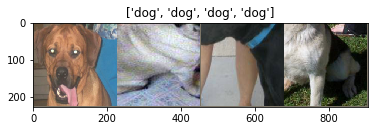

In [2]:
random.seed(1)
#P 1.1
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'F:\SP2019\Machine_learning\HW4\img'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    record_vallosses = []
    record_trainlosses = []
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                record_trainlosses.append(epoch_loss)
            else:
                record_vallosses.append(epoch_loss)
                
            if (epoch+1) % 10 == 0:
                if phase == 'train':                
                    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                    print('-' * 10)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, record_vallosses, record_trainlosses

#P 1.3.1
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

#P 1.2
#===================================================================
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
#P 1.3.2
model_ft,record_vallosses,record_trainlosses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 9/49
----------
train Loss: 0.6904 Acc: 0.5380
val Loss: 0.6966 Acc: 0.5100
Epoch 19/49
----------
train Loss: 0.6904 Acc: 0.5380
val Loss: 0.6738 Acc: 0.5800
Epoch 29/49
----------
train Loss: 0.6875 Acc: 0.5440
val Loss: 0.6757 Acc: 0.5600
Epoch 39/49
----------
train Loss: 0.6854 Acc: 0.5540
val Loss: 0.6734 Acc: 0.5900
Epoch 49/49
----------
train Loss: 0.6886 Acc: 0.5520
val Loss: 0.6755 Acc: 0.5400
Training complete in 58m 18s
Best val Acc: 0.600000


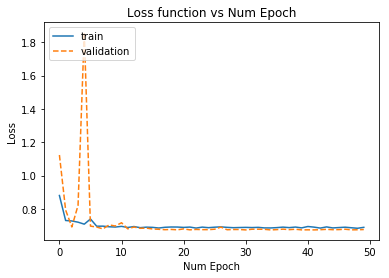

For training data:
Confusion Matrix : 
         act_0  act_1
pred_0     19     31
pred_1      9     41
Accuracy :  0.6
Sensitivity :  0.38
Specificity :  0.82
F1 score :  0.48717948717948717
None
For validation data:
Confusion Matrix : 
         act_0  act_1
pred_0     82    168
pred_1     58    192
Accuracy :  0.548
Sensitivity :  0.328
Specificity :  0.768
F1 score :  0.4205128205128206
None


In [12]:
#P 1.3.3
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

def calculate_stats (predict, label):
    column_names = ['act_0', 'act_1']
    row_names    = ['pred_0','pred_1']
    cm1 = confusion_matrix(predict, label)
    df = pd.DataFrame(cm1, columns=column_names, index=row_names)
    print('Confusion Matrix : \n', df)
    total1 = sum(sum(cm1))
    accuracy1 = (cm1[0, 0] + cm1[1, 1]) / total1
    print('Accuracy : ', accuracy1)
    sensitivity1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    print('Sensitivity : ', sensitivity1)
    specificity1 = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    print('Specificity : ', specificity1)
    recall = cm1[0, 0] / (cm1[0, 0] + cm1[1, 0])
    precision = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    Fscore = 2 * precision * recall / (precision + recall)
    print("F1 score : ", Fscore)
    return

plt.plot(record_trainlosses, linestyle='solid',label = "train")
plt.plot(record_vallosses, linestyle='dashed',label = "validation")
plt.legend(loc='upper left')
plt.title('Loss function vs Num Epoch')
plt.xlabel('Num Epoch')
plt.ylabel('Loss')
plt.show()


predictedt = []
labelst = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)
        for j in range(inputs.size()[0]):
            labelst.append(labels[j].cpu().numpy())
            predictedt.append(preds[j].cpu().numpy())
            
predictedv = []
labelsv = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft(inputs)
        _, preds = torch.max(output, 1)
        for j in range(inputs.size()[0]):
            labelsv.append(labels[j].cpu().numpy())
            predictedv.append(preds[j].cpu().numpy())
print("For training data:")            
print(calculate_stats(labelsv, predictedv))
print("="*20)
print("For validation data:")
print(calculate_stats(labelst, predictedt))


In [3]:
# P 1.4
#==========================================================================
#P 1.4.1
def train_model_2(model, criterion, optimizer, scheduler, num_epochs=25):
    
    record_trainlosses2 = []
    record_vallosses2 = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                record_vallosses2.append(epoch_loss)
            else:
                record_trainlosses2.append(epoch_loss)
                
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,record_vallosses2,record_trainlosses2



In [4]:
model_ft_2 = models.resnet18(pretrained=True)
for param in model_ft_2.parameters():
    param.requires_grad = False
    
num_ftrs_2 = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs_2, 2)
model_ft_2 = model_ft_2.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft_2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
#P 1.4.2
model_ft_2,record_vallosses2,record_trainlosses2 = train_model_2(model_ft_2, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4800 Acc: 0.7440
val Loss: 0.1395 Acc: 0.9700

Epoch 1/19
----------
train Loss: 0.3786 Acc: 0.8100
val Loss: 0.1028 Acc: 0.9500

Epoch 2/19
----------
train Loss: 0.3981 Acc: 0.8100
val Loss: 0.0901 Acc: 0.9600

Epoch 3/19
----------
train Loss: 0.4064 Acc: 0.7960
val Loss: 0.0970 Acc: 0.9600

Epoch 4/19
----------
train Loss: 0.2972 Acc: 0.8800
val Loss: 0.0756 Acc: 0.9800

Epoch 5/19
----------
train Loss: 0.3287 Acc: 0.8560
val Loss: 0.0839 Acc: 0.9500

Epoch 6/19
----------
train Loss: 0.3144 Acc: 0.8580
val Loss: 0.0703 Acc: 0.9700

Epoch 7/19
----------
train Loss: 0.3286 Acc: 0.8660
val Loss: 0.0658 Acc: 0.9700

Epoch 8/19
----------
train Loss: 0.3391 Acc: 0.8420
val Loss: 0.0704 Acc: 0.9700

Epoch 9/19
----------
train Loss: 0.3149 Acc: 0.8680
val Loss: 0.0612 Acc: 0.9700

Epoch 10/19
----------
train Loss: 0.2880 Acc: 0.8640
val Loss: 0.0664 Acc: 0.9700

Epoch 11/19
----------
train Loss: 0.3105 Acc: 0.8820
val Loss: 0.0719 Acc: 0.9700

Ep

In [7]:
optimizer_ftV2 = optim.Adam(model_ft_2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_schedulerV2 = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft_2V2,record_vallossesV2,record_trainlossesV2 = train_model_2(model_ft_2, criterion, optimizer_ftV2, exp_lr_schedulerV2,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0706 Acc: 0.6800
val Loss: 0.0840 Acc: 0.9600

Epoch 1/19
----------
train Loss: 1.0337 Acc: 0.7620
val Loss: 0.2842 Acc: 0.9400

Epoch 2/19
----------
train Loss: 0.8375 Acc: 0.8140
val Loss: 0.1604 Acc: 0.9700

Epoch 3/19
----------
train Loss: 1.0389 Acc: 0.7760
val Loss: 0.3480 Acc: 0.9300

Epoch 4/19
----------
train Loss: 0.6753 Acc: 0.8440
val Loss: 0.1193 Acc: 0.9600

Epoch 5/19
----------
train Loss: 1.2116 Acc: 0.7680
val Loss: 0.0985 Acc: 0.9800

Epoch 6/19
----------
train Loss: 1.4347 Acc: 0.7840
val Loss: 0.2136 Acc: 0.9400

Epoch 7/19
----------
train Loss: 1.0408 Acc: 0.8240
val Loss: 0.0618 Acc: 0.9700

Epoch 8/19
----------
train Loss: 0.7967 Acc: 0.8380
val Loss: 0.1367 Acc: 0.9500

Epoch 9/19
----------
train Loss: 0.8097 Acc: 0.8520
val Loss: 0.0675 Acc: 0.9800

Epoch 10/19
----------
train Loss: 1.0556 Acc: 0.8020
val Loss: 0.0622 Acc: 0.9700

Epoch 11/19
----------
train Loss: 1.1813 Acc: 0.8020
val Loss: 1.4287 Acc: 0.7600

Ep

In [8]:
#P 1.4.2
optimizer_ftV3 = optim.Adam(model_ft_2.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_schedulerV3 = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft_2V3,record_vallossesV3,record_trainlossesV3 = train_model_2(model_ft_2, criterion, optimizer_ftV3, exp_lr_schedulerV3,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8663 Acc: 0.8240
val Loss: 0.0879 Acc: 0.9800

Epoch 1/19
----------
train Loss: 0.7457 Acc: 0.8260
val Loss: 0.1278 Acc: 0.9700

Epoch 2/19
----------
train Loss: 0.7533 Acc: 0.8180
val Loss: 0.1633 Acc: 0.9400

Epoch 3/19
----------
train Loss: 0.7691 Acc: 0.8140
val Loss: 0.1747 Acc: 0.9400

Epoch 4/19
----------
train Loss: 0.7445 Acc: 0.8180
val Loss: 0.0614 Acc: 0.9900

Epoch 5/19
----------
train Loss: 0.6171 Acc: 0.8400
val Loss: 0.1032 Acc: 0.9400

Epoch 6/19
----------
train Loss: 0.6923 Acc: 0.8120
val Loss: 0.0969 Acc: 0.9600

Epoch 7/19
----------
train Loss: 0.5487 Acc: 0.8340
val Loss: 0.1763 Acc: 0.9400

Epoch 8/19
----------
train Loss: 0.6739 Acc: 0.8160
val Loss: 0.1133 Acc: 0.9800

Epoch 9/19
----------
train Loss: 0.5665 Acc: 0.8400
val Loss: 0.1257 Acc: 0.9600

Epoch 10/19
----------
train Loss: 0.5773 Acc: 0.8460
val Loss: 0.1105 Acc: 0.9600

Epoch 11/19
----------
train Loss: 0.6371 Acc: 0.8420
val Loss: 0.1391 Acc: 0.9500

Ep

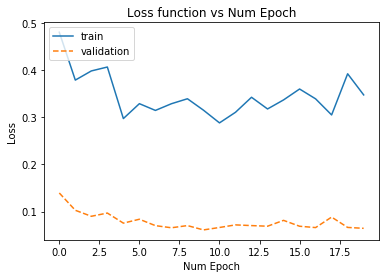

In [6]:
# P 1.4.2
import matplotlib.pyplot as plt

plt.plot(record_trainlosses2, linestyle='solid',label = "train")
plt.plot(record_vallosses2, linestyle='dashed',label = "validation")
plt.legend(loc='upper left')
plt.title('Loss function vs Num Epoch')
plt.xlabel('Num Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
# P 1.4.2
from sklearn.metrics import confusion_matrix

predictedt = []
labelst = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft_2(inputs)
        _, preds = torch.max(output, 1)
        #prediction = torch.max(output.data, 1)[1]
        #prediction = predicted.data.cpu().numpy().argmax()
        for j in range(inputs.size()[0]):
            labelst.append(labels[j].cpu().numpy())
            predictedt.append(preds[j].cpu().numpy())
            
predictedv = []
labelsv = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft_2(inputs)
        _, preds = torch.max(output, 1)
        for j in range(inputs.size()[0]):
            labelsv.append(labels[j].cpu().numpy())
            predictedv.append(preds[j].cpu().numpy())
print("for trainig data:")
print(calculate_stats(predictedv, labelsv))
print('='*20)
print("for validation data:")
print(calculate_stats(predictedt, labelst))

for trainig data:
Confusion Matrix : 
         act_0  act_1
pred_0     49      1
pred_1      1     49
Accuracy :  0.98
Sensitivity :  0.98
Specificity :  0.98
F1 score :  0.98
None
for validation data:
Confusion Matrix : 
         act_0  act_1
pred_0    246     20
pred_1      4    230
Accuracy :  0.952
Sensitivity :  0.924812030075188
Specificity :  0.9829059829059829
F1 score :  0.9534883720930233
None


3. How is the training on the pre-trained model different from the non pre-
trained model?

The accuracy is much better for pre-trained model. This is understandable because the pre-trained model has much more training samples. 

# P2
1. Give a short description of your approach, including training/validation/testing
split, overall architecture, word embeddings. This should also include the choice
of optimizer and loss functions. (5 points)

The overall architecture will be a LSTM RNN, with training/val/test split as 70%, 15% 15%. We will use glove.6B.100d as the word embedding. The optimizer will be a Adam and loss function will be cross entropy since the labels are binary.

2. Train a model, and return your results on a held-out test set. This should
include a training/validation error graph (10 points).

In [18]:

from torchtext import data
import spacy
import torch

#def tokenizer(text): # create a tokenizer function
#    return [tok.text for tok in spacy_en.tokenizer(text)]
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy',include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)

tv_datafields = [('text', TEXT), ("label", LABEL)]

total_data = data.TabularDataset(
               path="F:\SP2019\Machine_learning\HW4\yelp_labelled.txt", # the root directory where the data lies
               format='tsv',
               skip_header=False, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=tv_datafields)

import random
train_data,test_data = total_data.split(random_state = random.seed(1233),split_ratio=0.85)
train_data,valid_data = train_data.split(random_state = random.seed(1233),split_ratio=0.7/0.85)

MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(
    dataset=train_data, batch_size=BATCH_SIZE,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device = device)

valid_iterator = data.BucketIterator(
    dataset=valid_data, batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

test_iterator = data.BucketIterator(
    dataset=test_data, batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)



import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
                
        embedded = self.dropout(self.embedding(text))
                
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))            
        return self.fc(hidden.squeeze(0))

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.35
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    #y = y -2
    rounded_preds = torch.round(torch.sigmoid(preds))
    #print(rounded_preds)
    #print(y)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text,text_lengths =  batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
                
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            #print(predictions)
            #print(batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The model has 820,141 trainable parameters
torch.Size([1891, 100])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.1746,  0.2807, -0.4946,  ..., -0.5715,  0.3390,  0.7452],
        [ 0.2911,  0.1218, -0.1307,  ...,  0.2353,  0.3025, -0.0789],
        [-0.4735, -0.4899,  1.3609,  ...,  0.6387,  0.2690, -0.0217]])


In [24]:
N_EPOCHS = 50

best_valid_loss = float('inf')
train_loss_list = []
val_loss_list = []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    #print(type(train_iterator))
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.013 | Train Acc: 99.57%
	 Val. Loss: 1.177 |  Val. Acc: 78.96%
Epoch: 10 | Epoch Time: 0m 2s
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.038 |  Val. Acc: 79.17%
Epoch: 15 | Epoch Time: 0m 2s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.180 |  Val. Acc: 77.92%
Epoch: 20 | Epoch Time: 0m 2s
	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 0.988 |  Val. Acc: 77.92%
Epoch: 25 | Epoch Time: 0m 2s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.086 |  Val. Acc: 77.92%
Epoch: 30 | Epoch Time: 0m 2s
	Train Loss: 0.020 | Train Acc: 99.29%
	 Val. Loss: 0.834 |  Val. Acc: 77.92%
Epoch: 35 | Epoch Time: 0m 3s
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.327 |  Val. Acc: 78.54%
Epoch: 40 | Epoch Time: 0m 2s
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.375 |  Val. Acc: 77.92%
Epoch: 45 | Epoch Time: 0m 2s
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 1.083 |  Val. Acc: 77.92%
Epoch: 50 | Epoch Tim

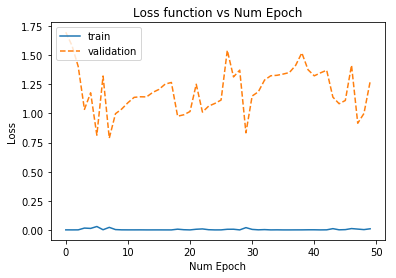

In [25]:
import matplotlib.pyplot as plt
xaxis = range(0,50)

plt.plot(train_loss_list, linestyle='solid',label = "train")
plt.plot(val_loss_list, linestyle='dashed',label = "validation")
plt.legend(loc='upper left')
plt.title('Loss function vs Num Epoch')
plt.xlabel('Num Epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.735 | Test Acc: 83.96%


3. Describe your results (10 points).

We found that the accuracy is quite good for the test dataset. It is surprising that the accuracy on test set is better than validation set. 
Another thing is that we found that the training accuracy is high but the validation accuracy is relatively low. This may indicate that my model is overfitting. But given 80% accuracy the performance is satisfactory.
From the loss graph we see that the validation loss keeps flactuating. This may indicate that I either found the minimum point or the optimizer was stuck in a plateau. 